# Extended BUMP Analysis

## Preparation

#### Import dependencies

In [1]:
import ast
from collections import Counter
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.stats import chi2_contingency

#### Configure plots look and feel

In [2]:
def set_plot_theme(base_font: int) -> None:
    """ 
    Set the theme for plots in the notebook.
    """
    sns.set_theme(
        style="whitegrid", 
        context="talk", 
        palette="colorblind",
        rc={
            "font.size": base_font, 
            "axes.titlesize": base_font + 4, 
            "axes.labelsize": base_font + 2,
            "xtick.labelsize": base_font,
            "ytick.labelsize": base_font,
            "legend.fontsize": base_font
            })
    
    mpl.rcParams.update({
        "figure.titlesize": base_font + 4,
        "axes.titlepad": 30,
        "axes.labelpad": 10,
        })

set_plot_theme(10)

#### Read dataset

In [3]:
path = "data/bc_type_distribution_full_data.csv"
df = pd.read_csv(path)
df.head()

,BC_kinds,#files with this BC_kinds,BC_kinds_count,absolute_path_to_file_in_container,file_success,breakingCommit,model,build_success
0,NONE,107,0,/singer/singer-commons/src/main/java/com/pinte...,True,067f5d2c81ff87c90755f4ed48f62eb5faa8ecf9,gpt-5,True
1,NONE,107,0,/cyclonedx-maven-plugin/src/main/java/org/cycl...,True,1ee7d41d41fa991bbd52fc226a217de8fccf8e32,gpt-5,False
2,NONE,107,0,/cyclonedx-maven-plugin/src/main/java/org/cycl...,True,1ee7d41d41fa991bbd52fc226a217de8fccf8e32,gpt-5,False
3,NONE,107,0,/depclean/depclean-core/src/main/java/se/kth/d...,True,b86a5f84b44a9b50aee69745886c47123f721de3,gpt-5,False
4,NONE,107,0,/artifactory-plugin/src/main/java/org/jfrog/hu...,True,b5b64613a1a650a5784ff39386b4e00e05e5c21c,gpt-5,False


## Analysis

#### Compute number of files

In [4]:
files = len(df)
print(f"Total files: {files}")

Total files: 376


#### Identify breaking and non-breaking files

In [5]:
bc_files = df[df["BC_kinds"] != "NONE"]
bc_count = len(bc_files)

none_files = df[df["BC_kinds"] == "NONE"]
none_count = len(none_files)

print(f"Files with breaking changes: {bc_count} ({(bc_count / files) * 100:.2f}%)")
print(f"Files with no breaking changes: {none_count} ({(none_count / files) * 100:.2f}%)")

Files with breaking changes: 269 (71.54%)
Files with no breaking changes: 107 (28.46%)


#### Compute number of BC types per file

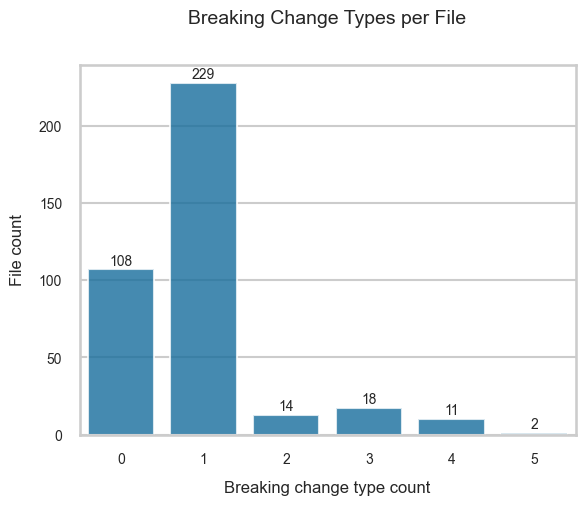

In [6]:
ax = sns.countplot(
    x="BC_kinds_count",
    data=df,
    order=sorted(df["BC_kinds_count"].unique())
)

for p in ax.patches:
    p.set_alpha(0.8)
    height = p.get_height() + 1
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')

ax.set_title("Breaking Change Types per File")
ax.set_xlabel("Breaking change type count")
ax.set_ylabel("File count")

# plt.tight_layout()
plt.show()

In [7]:
def parse_bcs_labels(labels: str) -> list[str]:
    """
    Parses the breaking change labels from a string and returns a list 
    of breaking change types (e.g., METHOD_REMOVED, METHOD_ADDED_TO_INTERFACE,
    NONE). If the input is NaN or not a string, it returns an empty list.

    :param labels: A string containing the breaking change labels separated 
        by semicolons.
    :return: A list of breaking change types.
    """
    if not pd.isna(labels) and isinstance(labels, str):
        return [label.strip() for label in labels.split(";")]
    return []

In [8]:
df["bc_types"] = df["BC_kinds"].apply(parse_bcs_labels)
df.tail()

,BC_kinds,#files with this BC_kinds,BC_kinds_count,absolute_path_to_file_in_container,file_success,breakingCommit,model,build_success,bc_types
371,METHOD_ADDED_TO_INTERFACE; METHOD_REMOVED; SUP...,8,4,/jadler/jadler-jetty/src/main/java/net/jadler/...,True,95b2c15de16fd9fd612ce73672e29b613ce7a909,gpt-5,False,"[METHOD_ADDED_TO_INTERFACE, METHOD_REMOVED, SU..."
372,METHOD_ADDED_TO_INTERFACE; METHOD_REMOVED; SUP...,8,4,/jadler/jadler-jetty/src/main/java/net/jadler/...,True,5287fc631fa78e7f11d39983824cdd4215b9a03b,gpt-5,False,"[METHOD_ADDED_TO_INTERFACE, METHOD_REMOVED, SU..."
373,METHOD_ABSTRACT_ADDED_TO_CLASS; METHOD_ADDED_T...,1,4,/liquibase-mssql/src/java/liquibase/ext/mssql/...,True,feb582661e77de66eadaa7550720a8751b266ee4,gpt-5,False,"[METHOD_ABSTRACT_ADDED_TO_CLASS, METHOD_ADDED_..."
374,METHOD_ADDED_TO_INTERFACE; METHOD_REMOVED; MET...,1,4,/java-pubsub-group-kafka-connector/src/main/ja...,True,d54b56b91c11f21b97d4903143b04b7c1f10c255,gpt-5,False,"[METHOD_ADDED_TO_INTERFACE, METHOD_REMOVED, ME..."
375,METHOD_ADDED_TO_INTERFACE; METHOD_NOW_FINAL; M...,1,5,/bval/bval-jsr/src/test/java/org/apache/bval/j...,True,2dfaa41bfb97674d11f09a5885011f19808548a3,gpt-5,False,"[METHOD_ADDED_TO_INTERFACE, METHOD_NOW_FINAL, ..."


In [9]:
multi_label_bc_type_counts = Counter(df["bc_types"].explode().tolist())
single_label_counts = Counter([bc_types[0] for bc_types in df["bc_types"] if len(bc_types) == 1])

# Multi-label files
bc_types_distribution = pd.DataFrame.from_dict(multi_label_bc_type_counts, orient="index", columns=["multi-label-files"])
bc_types_distribution["multi-label-files-perc"] = bc_types_distribution["multi-label-files"] / files * 100
bc_types_distribution = bc_types_distribution.sort_values("multi-label-files", ascending=False)

# Single-label files
single_label_df = pd.DataFrame.from_dict(single_label_counts, orient="index", columns=["single-label-files"])
single_label_df["single-label-files-perc"] = single_label_df["single-label-files"] / files * 100

# Join both dataframes and fill missing values with zeros
bc_types_distribution = bc_types_distribution.join(single_label_df, how="left", on=None, validate="many_to_many")
bc_types_distribution["single-label-files"] = bc_types_distribution["single-label-files"].fillna(0).astype(int)
bc_types_distribution["single-label-files-perc"] = bc_types_distribution["single-label-files-perc"].fillna(0)

bc_types_distribution


,multi-label-files,multi-label-files-perc,single-label-files,single-label-files-perc
TYPE_REMOVED,195,51.861702,165,43.882979
NONE,107,28.457447,107,28.457447
METHOD_REMOVED,77,20.478723,52,13.829787
METHOD_ADDED_TO_INTERFACE,21,5.585106,2,0.531915
SUPERTYPE_REMOVED,14,3.723404,2,0.531915
FIELD_REMOVED,13,3.457447,3,0.797872
FIELD_TYPE_CHANGED,10,2.659574,0,0.000000
METHOD_RETURN_TYPE_CHANGED,8,2.127660,0,0.000000
METHOD_NO_LONGER_THROWS_CHECKED_EXCEPTION,3,0.797872,3,0.797872
METHOD_NOW_FINAL,3,0.797872,0,0.000000


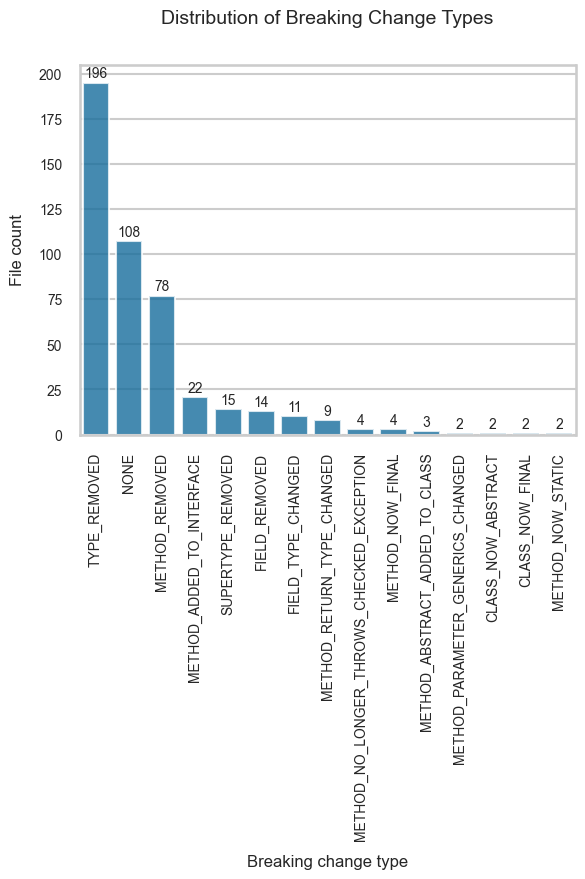

In [10]:
# Data
ax = sns.barplot(
    x=bc_types_distribution.index, 
    y=bc_types_distribution["multi-label-files"]
)
plt.xticks(rotation=90)

# Annotations
for p in ax.patches:
    p.set_alpha(0.8)
    height = p.get_height() + 1
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')

# Labels
ax.set_title("Distribution of Breaking Change Types")
ax.set_xlabel("Breaking change type")
ax.set_ylabel("File count")

plt.show()

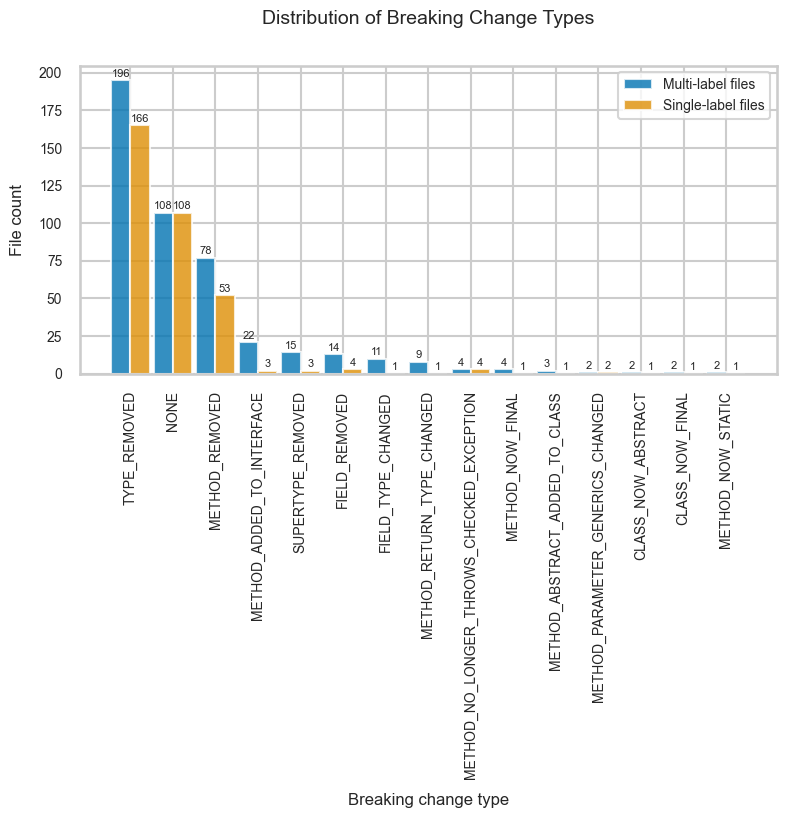

In [11]:
# Data
fig, ax = plt.subplots(figsize=(max(6, len(bc_types_distribution) * 0.6), 4))
x = np.arange(len(bc_types_distribution))
width = 0.45
ax.bar(x - width / 2, bc_types_distribution['multi-label-files'], width, label='Multi-label files')
ax.bar(x + width / 2, bc_types_distribution['single-label-files'], width, label='Single-label files')
ax.set_xticks(x)
ax.set_xticklabels(bc_types_distribution.index, rotation=90)

# Annotations
for p in ax.patches:
    p.set_alpha(0.8)
    height = p.get_height() + 1
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=8)

# Labels
ax.set_title("Distribution of Breaking Change Types")
ax.set_xlabel("Breaking change type")
ax.set_ylabel("File count")
ax.legend()

plt.show()

#### Remove files with NONE as BC

In [12]:
len_before = len(df)
df = df[df["BC_kinds"] != "NONE"]
len_after = len(df)
print(f"Removed {len_before - len_after} files with BC_kinds NONE. Remaining files: {len_after}")

Removed 107 files with BC_kinds NONE. Remaining files: 269


#### Extract project information

In [13]:
df["project"] = df["absolute_path_to_file_in_container"].apply(lambda x: x.split("/")[1])
df.head()

,BC_kinds,#files with this BC_kinds,BC_kinds_count,absolute_path_to_file_in_container,file_success,breakingCommit,model,build_success,bc_types,project
107,TYPE_REMOVED,165,1,/license-maven-plugin/license-maven-plugin/src...,True,fb038ef3a078e45abab4ecc6728a3d0d89bbe01f,gpt-5,False,[TYPE_REMOVED],license-maven-plugin
108,TYPE_REMOVED,165,1,/openfire-hazelcast-plugin/src/java/org/jiveso...,True,2b4d49d68112941b8abb818549389709d8327963,gpt-5,False,[TYPE_REMOVED],openfire-hazelcast-plugin
109,TYPE_REMOVED,165,1,/XChange/xchange-stream-service-pubnub/src/mai...,False,7f411529addceb9e6e43898e84c559e209764f0a,gpt-5,False,[TYPE_REMOVED],XChange
110,TYPE_REMOVED,165,1,/jcabi-s3/src/test/java/com/jcabi/s3/AwsOcketI...,True,24d4a90ec1b375751e71f33d18949405c9529d77,gpt-5,True,[TYPE_REMOVED],jcabi-s3
111,TYPE_REMOVED,165,1,/license-maven-plugin/license-maven-plugin/src...,True,fb038ef3a078e45abab4ecc6728a3d0d89bbe01f,gpt-5,False,[TYPE_REMOVED],license-maven-plugin


In [14]:
projects = df["project"].unique()
print(f"Unique projects: {len(projects)}")

Unique projects: 59


In [15]:
project_counts = Counter(df["project"].explode().tolist())
project_distribution = pd.DataFrame.from_dict(project_counts, orient="index", columns=["file-count"])
project_distribution["file-count-perc"] = project_distribution["file-count"] / files * 100
project_distribution = project_distribution.sort_values("file-count", ascending=False)
project_distribution

,file-count,file-count-perc
license-maven-plugin,30,7.978723
rtree,24,6.382979
jakartaee-mvc-sample,20,5.319149
ChangeSkin,15,3.989362
google-cloud-java,14,3.723404
nem,14,3.723404
XChange,11,2.925532
jadler,9,2.393617
java-api,8,2.127660
PGS,6,1.595745


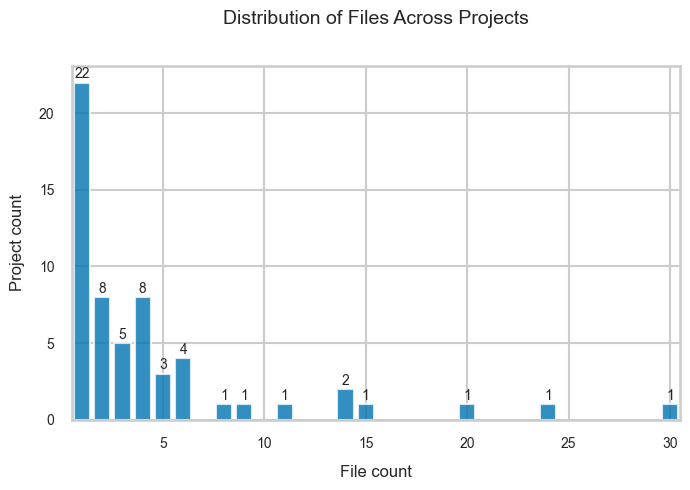

In [16]:
file_count_distribution = project_distribution["file-count"].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(7, 5))
ax.bar(file_count_distribution.index, file_count_distribution.values)

min_count = int(file_count_distribution.index.min())
max_count = int(file_count_distribution.index.max())
ax.set_xlim(min_count - 0.5, max_count + 0.5)

# Annotations
for p in ax.patches:
    p.set_alpha(0.8)
    height = p.get_height() + 0.1
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')

# Labels
ax.set_title("Distribution of Files Across Projects")
ax.set_xlabel("File count")
ax.set_ylabel("Project count")

plt.tight_layout()
plt.show()

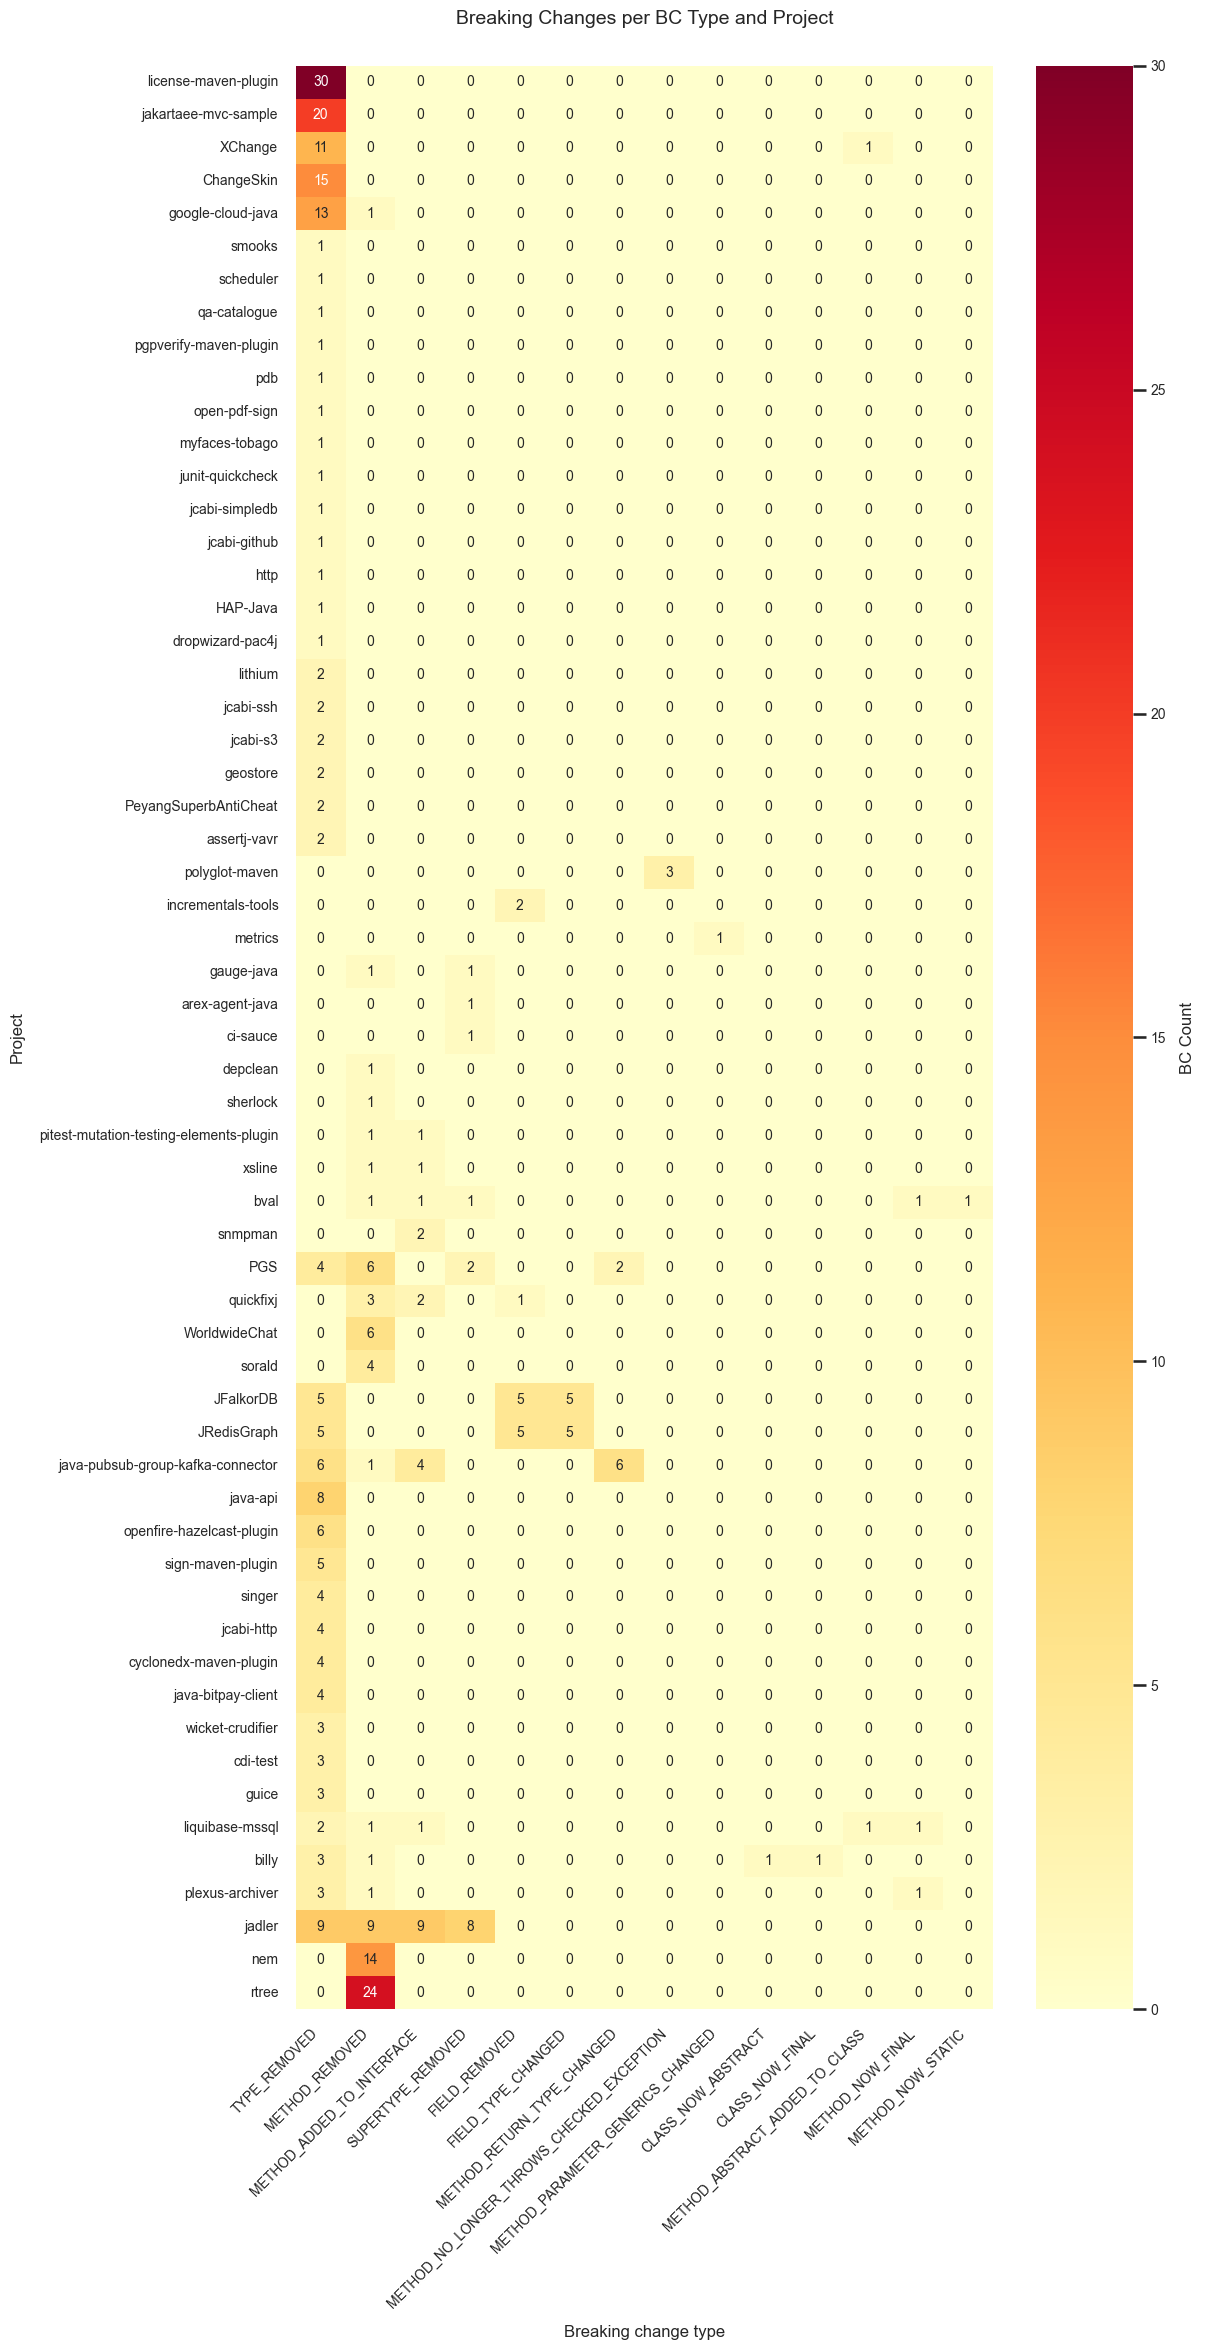

In [17]:
exploded_df = df[['bc_types', 'project']].explode('bc_types')
heatmap_data = exploded_df.groupby(['project', 'bc_types']).size().unstack(fill_value=0)

# Perform hierarchical clustering to determine ordering
row_linkage = linkage(pdist(heatmap_data.fillna(0), metric='euclidean'), method='ward')
col_linkage = linkage(pdist(heatmap_data.T.fillna(0), metric='euclidean'), method='ward')

row_order = dendrogram(row_linkage, no_plot=True)['leaves']
col_order = dendrogram(col_linkage, no_plot=True)['leaves']
heatmap_data_ordered = heatmap_data.iloc[row_order, col_order]

fig, ax = plt.subplots(figsize=(max(12, len(heatmap_data.columns) * 0.6), max(8, len(heatmap_data) * 0.4)))
sns.heatmap(heatmap_data_ordered, annot=True, fmt='d', cmap='YlOrRd', cbar_kws={'label': 'BC Count'}, ax=ax)

ax.set_title('Breaking Changes per BC Type and Project')
ax.set_xlabel('Breaking change type')
ax.set_ylabel('Project')

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Train/Test Split

**Current situation**
- Each file has more than one BC type, resulting in a multi-labeled dataset.
- We should prevent label imbalance when performing the split. This is more challenging given the multi-labeled nature of the dataset.
- We need to ensure we end up witha representative coverage of all BC types available in the dataset for bot the training and test datasets. 
- We do not cover all possible BC types due to the current dataset we count on. This should be reported in the threats to validity.

**Alternatives to perform the split**
- Random sampling with a final check would be possible if the dataset was not that small (as it is our case).
- Multi-label stratified split: guarantees that each split preserves the proportion of labels (aka. BC types) in the training and test datasets. We account for the multi-label nature of the dataset---a simple stratified split could fail.
- Multi-label stratified k-fold or cross-validation: prevents us from focusing on "too good" or "too bad" cases. Although ideal, it might become too computationally expensive.

#### Multi-label stratified split

In [18]:
binarizer = MultiLabelBinarizer()
Y = binarizer.fit_transform(df["bc_types"])

splitter = MultilabelStratifiedShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=42
)

train_idx, test_idx = next(splitter.split(df, Y))

train_df = df.iloc[train_idx]
df = df.iloc[test_idx]
remaining_df = train_df.copy()

print(f"Size of training set: {len(train_df)} files")
print(f"Size of test set: {len(df)} files")

Size of training set: 214 files
Size of test set: 55 files


In [19]:
df.to_csv("data/test_set.csv", index=False)

#### Split the training dataset

In [20]:
def sample_training_set(base_df: pd.DataFrame, size: int, seed: int=42) -> pd.DataFrame:
    """
    Randomly samples a subset of the training data.
    
    :param base_df: The DataFrame to sample from.
    :param size: The number of samples to draw.
    :param seed: The random seed for reproducibility.
    :return: A DataFrame containing the sampled training data.
    """
    return base_df.sample(n=size, random_state=seed)

In [21]:
def compute_label_distribution(df: pd.DataFrame) -> Counter:
    """
    Computes the distribution of breaking change types in the given 
    DataFrame.
    
    :param df: The DataFrame containing a "bc_types" column with lists 
        of breaking change types.
    :return: A Counter object mapping each breaking change type to its count.
    """
    return Counter([",".join(sorted(labels)) for labels in df["bc_types"]])


def is_training_dataset_balanced(train_df: pd.DataFrame, test_df: pd.DataFrame, alpha: float=0.05) -> tuple[bool, float, float, float]:
    """
    Performs a chi-squared test to determine if the distribution of 
    breaking change types in the training set is statistically similar 
    to that in the test set.

    :param train_df: The training DataFrame.
    :param test_df: The test DataFrame.
    :param alpha: The significance level for the test (default is 0.05).
    :return: A tuple (is_balanced, p_value, chi2_statistic, cramers_v) where 
        is_balanced is True if the distributions are similar, False otherwise."""
    train_dist = compute_label_distribution(train_df)
    test_dist = compute_label_distribution(test_df)

    contingency = pd.DataFrame({
        "train": train_dist,
        "test": test_dist
    }).fillna(0)

    chi2, p_value, dof, expected = chi2_contingency(contingency)

    # Calculate Cramér's V (effect size)
    n = contingency.to_numpy().sum()
    cramers_v = np.sqrt(chi2 / (n * (min(contingency.shape) - 1)))

    return p_value >= alpha, p_value, chi2, cramers_v

In [22]:
def compute_next_sample_size(previous_sample_size: int, sample_increment: int, total_train: int) -> int:
    """
    Computes the next sample size for the training dataset based on the previous sample size,
    the sample increment, and the total number of training samples available.

    :param previous_sample_size: The size of the previous training dataset.
    :param sample_increment: The number of additional samples to add in the next round.
    :param total_train: The total number of training samples available.
    :return: The computed sample size for the next training dataset.
    """
    if previous_sample_size == 1:
        return sample_increment
    elif previous_sample_size + sample_increment > total_train:
        return total_train
    else:        
        return previous_sample_size + sample_increment
    

def create_training_datasets(df: pd.DataFrame, sample_increment: int=25, min_train_size: int=1, rounds: int=5) -> None:
    """
    Creates multiple training datasets of increasing size and checks 
    if they are balanced with respect to the test set. Collects metadata rows in a list and
    concatenates them into `meta_df` once at the end to avoid using the deprecated `append`.
    
    :param df: The DataFrame to sample from for creating training datasets.
    :param sample_increment: The number of additional samples to add in each round.
    :param min_train_size: The minimum number of samples for the training dataset.
    :param rounds: The number of training datasets to create.
    """
    total_train = len(df)
    sample_size = min_train_size
    meta_df = pd.DataFrame(columns=[
        "sample_size", 
        "round", 
        "dataset_path",
        "attempts", 
        "failed_attempts", 
        "chi2_statistic", 
        "p_value", 
        "cramers_v"])
    meta_rows = []

    while sample_size != total_train:
        _round = 0
        failed_attempts = 0

        while _round < rounds:
            print(f"Creating training dataset for round {_round + 1} with {sample_size} samples...")
            train_df = sample_training_set(df, sample_size)
            is_balanced, p_value, chi2, cramers_v = is_training_dataset_balanced(train_df, df, alpha=0.01)
        
            if not is_balanced:
                failed_attempts += 1
                print(f"Dataset for round {_round + 1} is imbalanced (p-value: {p_value:.4f}). Skipping this round.")
                continue
            
            path = f"data/train_{sample_size}_round_{_round}.csv"
            train_df.to_csv(path, index=False)
            meta_rows.append({
                "sample_size": sample_size,
                "round": _round,
                "dataset_path": path,
                "attempts": failed_attempts + 1,
                "failed_attempts": failed_attempts,
                "chi2_statistic": chi2,
                "p_value": p_value,
                "cramers_v": cramers_v
            })
            _round += 1

        print(f"Completed round {_round}.")
        sample_size = compute_next_sample_size(sample_size, sample_increment, total_train)
        print(f"Moving to next round with {sample_size} samples...")
    
    if meta_rows:
        meta_df = pd.concat([meta_df, pd.DataFrame(meta_rows)], ignore_index=True)
    meta_df.to_csv("data/train_datasets_meta.csv", index=False)

In [23]:
create_training_datasets(remaining_df)

Creating training dataset for round 1 with 1 samples...
Creating training dataset for round 2 with 1 samples...
Creating training dataset for round 3 with 1 samples...
Creating training dataset for round 4 with 1 samples...
Creating training dataset for round 5 with 1 samples...
Completed round 5.
Moving to next round with 25 samples...
Creating training dataset for round 1 with 25 samples...
Creating training dataset for round 2 with 25 samples...
Creating training dataset for round 3 with 25 samples...
Creating training dataset for round 4 with 25 samples...
Creating training dataset for round 5 with 25 samples...
Completed round 5.
Moving to next round with 50 samples...
Creating training dataset for round 1 with 50 samples...
Creating training dataset for round 2 with 50 samples...
Creating training dataset for round 3 with 50 samples...
Creating training dataset for round 4 with 50 samples...
Creating training dataset for round 5 with 50 samples...
Completed round 5.
Moving to nex

#### BC-based training dataset

In [24]:
def get_sample_per_bc_type(df: pd.DataFrame, bc_type: str) -> pd.DataFrame:
    """
    Returns the number of files in the df that contain only the specified breaking change type.

    :param df: The DataFrame to check for available files.
    :param bc_type: The breaking change type to filter by.
    :return: The number of files that contain only the specified breaking change type.
    """
    return df[df["bc_types"].apply(
        lambda x: isinstance(x, list) and len(x) == 1 and x[0] == bc_type
    )]

def create_training_datasets_per_bc_type(df: pd.DataFrame, samples_per_type: int=40) -> None:
    """
    Creates training datasets where each round focuses on files containing 
    a specific breaking change type. For each BC type found in the df,
    it creates a training dataset containing only files with that label.
     
    :param df: The DataFrame to sample from for creating training datasets.
    :param samples_per_type: Number of samples to include in each training dataset.
    """
    bc_types = {bc_type for bc_types in df["bc_types"] for bc_type in bc_types}
    bc_types = sorted(bc_types)
    
    for bc_type in bc_types:
        available_sample = get_sample_per_bc_type(df, bc_type)
        if len(available_sample) >= samples_per_type:
            train_df = sample_training_set(available_sample, samples_per_type)
            print(f"Creating training dataset for round {bc_type} with {len(train_df)} samples...")
            train_df.to_csv(f"data/train_{bc_type}.csv", index=False)


In [25]:
create_training_datasets_per_bc_type(remaining_df)

Creating training dataset for round METHOD_REMOVED with 40 samples...
Creating training dataset for round TYPE_REMOVED with 40 samples...


## Post-analysis

#### Distribution of BC Types in Training/Test Sets

In [26]:
def compute_bc_type_distribution(path_dataset: str) -> pd.DataFrame:
    """
    Computes the distribution of breaking change types in the given dataset.
    
    :param path_dataset: The path to the CSV file containing a "bc_types" column with lists of breaking change types.
    :return: A DataFrame with columns "BC Type", "Single-label Files", "Multi-label Files", and "Total Files".
    """
    test_df = pd.read_csv(path_dataset)
    test_df["bc_types"] = test_df["bc_types"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    
    test_df["num_labels"] = test_df["bc_types"].apply(len)
    test_df["is_single_label"] = test_df["num_labels"] == 1
    test_df["is_multi_label"] = test_df["num_labels"] > 1

    bc_types = sorted(test_df["bc_types"].explode().unique().tolist())
    results = []

    for bc_type in bc_types:
        has_bc_type = test_df['bc_types'].apply(lambda x, bc_type=bc_type: bc_type in x)
        subset = test_df[has_bc_type]
        
        single_label_count = subset['is_single_label'].sum()
        multi_label_count = subset['is_multi_label'].sum()
        total_count = len(subset)
        
        results.append({
            'BC Type': bc_type,
            'Single-label Files': single_label_count,
            'Multi-label Files': multi_label_count,
            'Total Files': total_count
        })

    return pd.DataFrame(results)

In [27]:
results_df = compute_bc_type_distribution('data/test_set.csv')
results_df

,BC Type,Single-label Files,Multi-label Files,Total Files
0,FIELD_REMOVED,1,2,3
1,FIELD_TYPE_CHANGED,0,2,2
2,METHOD_ADDED_TO_INTERFACE,0,4,4
3,METHOD_NOW_FINAL,0,1,1
4,METHOD_NO_LONGER_THROWS_CHECKED_EXCEPTION,1,0,1
5,METHOD_REMOVED,10,5,15
6,METHOD_RETURN_TYPE_CHANGED,0,2,2
7,SUPERTYPE_REMOVED,1,2,3
8,TYPE_REMOVED,34,5,39


In [28]:
def compute_project_distribution(path_dataset: str) -> pd.DataFrame:
    """
    Computes the distribution of files coming from unique projects in the given dataset.
    
    :param path_dataset: The path to the CSV file containing a "project" column with project identifiers.
    :return: A DataFrame with columns "Project", "File Count", and "Percentage".
    """
    df = pd.read_csv(path_dataset)
    project_counts = df['project'].value_counts()
    total_files = len(df)
    
    # Create results dataframe
    results = []
    for project, count in project_counts.items():
        percentage = (count / total_files) * 100
        results.append({
            'Project': project,
            'File Count': count,
            'Percentage': round(percentage, 2)
        })
    
    return pd.DataFrame(results)

project_dist_df = compute_project_distribution('data/test_set.csv')
project_dist_df

,Project,File Count,Percentage
0,license-maven-plugin,7,12.73
1,rtree,6,10.91
2,google-cloud-java,4,7.27
3,jakartaee-mvc-sample,4,7.27
4,singer,3,5.45
5,XChange,3,5.45
6,openfire-hazelcast-plugin,2,3.64
7,java-bitpay-client,2,3.64
8,ChangeSkin,2,3.64
9,java-api,2,3.64


#### Split Quality Assessment: BC Type Distribution Comparison

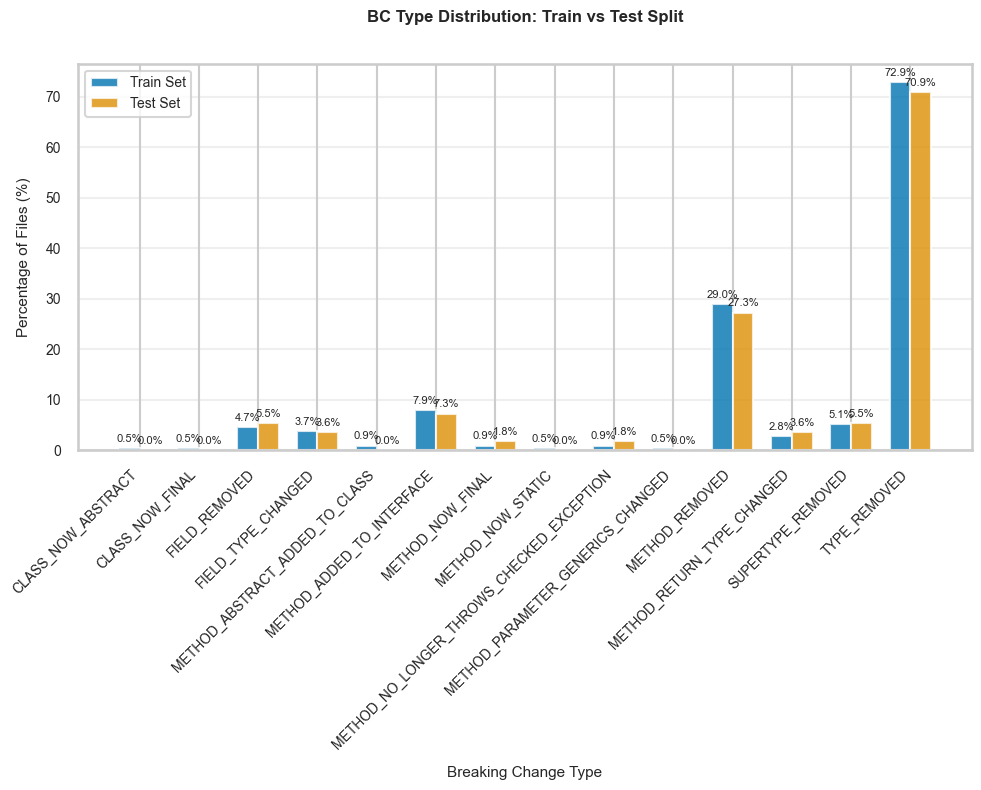

In [29]:
def compute_distribution_comparison(train_path: str, test_path: str, comparison_type: str = 'bc_type') -> pd.DataFrame:
    """
    Computes the distribution comparison between training and test datasets.
    
    :param train_path: Path to the training dataset CSV file.
    :param test_path: Path to the test dataset CSV file.
    :param comparison_type: Type of comparison - 'bc_type' or 'project'.
    :return: A DataFrame with distribution comparison.
    """
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    
    if comparison_type == 'bc_type':
        # Parse bc_types for breaking change type comparison
        train_df["bc_types"] = train_df["bc_types"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
        test_df["bc_types"] = test_df["bc_types"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
        
        train_values = set(train_df["bc_types"].explode().unique().tolist())
        test_values = set(test_df["bc_types"].explode().unique().tolist())
        all_values = sorted(train_values.union(test_values))
        
        comparison_data = []
        for value in all_values:
            train_count = train_df['bc_types'].apply(lambda x: value in x).sum()
            test_count = test_df['bc_types'].apply(lambda x: value in x).sum()
            
            train_pct = (train_count / len(train_df)) * 100
            test_pct = (test_count / len(test_df)) * 100
            
            comparison_data.append({
                'BC Type': value,
                'Train Count': train_count,
                'Test Count': test_count,
                'Train %': train_pct,
                'Test %': test_pct
            })
        
        return pd.DataFrame(comparison_data)
    
    elif comparison_type == 'project':
        # Project distribution comparison
        train_projects = set(train_df['project'].unique())
        test_projects = set(test_df['project'].unique())
        all_projects = sorted(train_projects.union(test_projects))
        
        comparison_data = []
        for project in all_projects:
            train_count = len(train_df[train_df['project'] == project])
            test_count = len(test_df[test_df['project'] == project])
            
            train_pct = (train_count / len(train_df)) * 100
            test_pct = (test_count / len(test_df)) * 100
            
            comparison_data.append({
                'Project': project,
                'Train Count': train_count,
                'Test Count': test_count,
                'Train %': train_pct,
                'Test %': test_pct
            })
        
        return pd.DataFrame(comparison_data)


def plot_bc_distribution_comparison(comparison_df: pd.DataFrame) -> None:
    """
    Visualizes the BC type distribution comparison between training and test datasets.
    
    :param comparison_df: A DataFrame with columns 'BC Type', 'Train %', 'Test %'.
    """
    bc_types_list = comparison_df['BC Type'].tolist()
    
    # Visualize BC type distribution comparison
    fig, ax = plt.subplots(figsize=(max(10, len(bc_types_list) * 0.7), 8))
    x = np.arange(len(bc_types_list))
    width = 0.35
    
    bars1 = ax.bar(x - width / 2, comparison_df['Train %'], width, label='Train Set', alpha=0.8)
    bars2 = ax.bar(x + width / 2, comparison_df['Test %'], width, label='Test Set', alpha=0.8)
    
    ax.set_ylabel('Percentage of Files (%)', fontsize=11)
    ax.set_xlabel('Breaking Change Type', fontsize=11)
    ax.set_title('BC Type Distribution: Train vs Test Split', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_df['BC Type'], rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.1f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()


# Compute comparison and plot
comparison_df = compute_distribution_comparison('data/train_df_analysis.csv', 'data/test_set.csv', comparison_type='bc_type')
plot_bc_distribution_comparison(comparison_df)

#### Split Quality Assessment: Project Distribution Balance

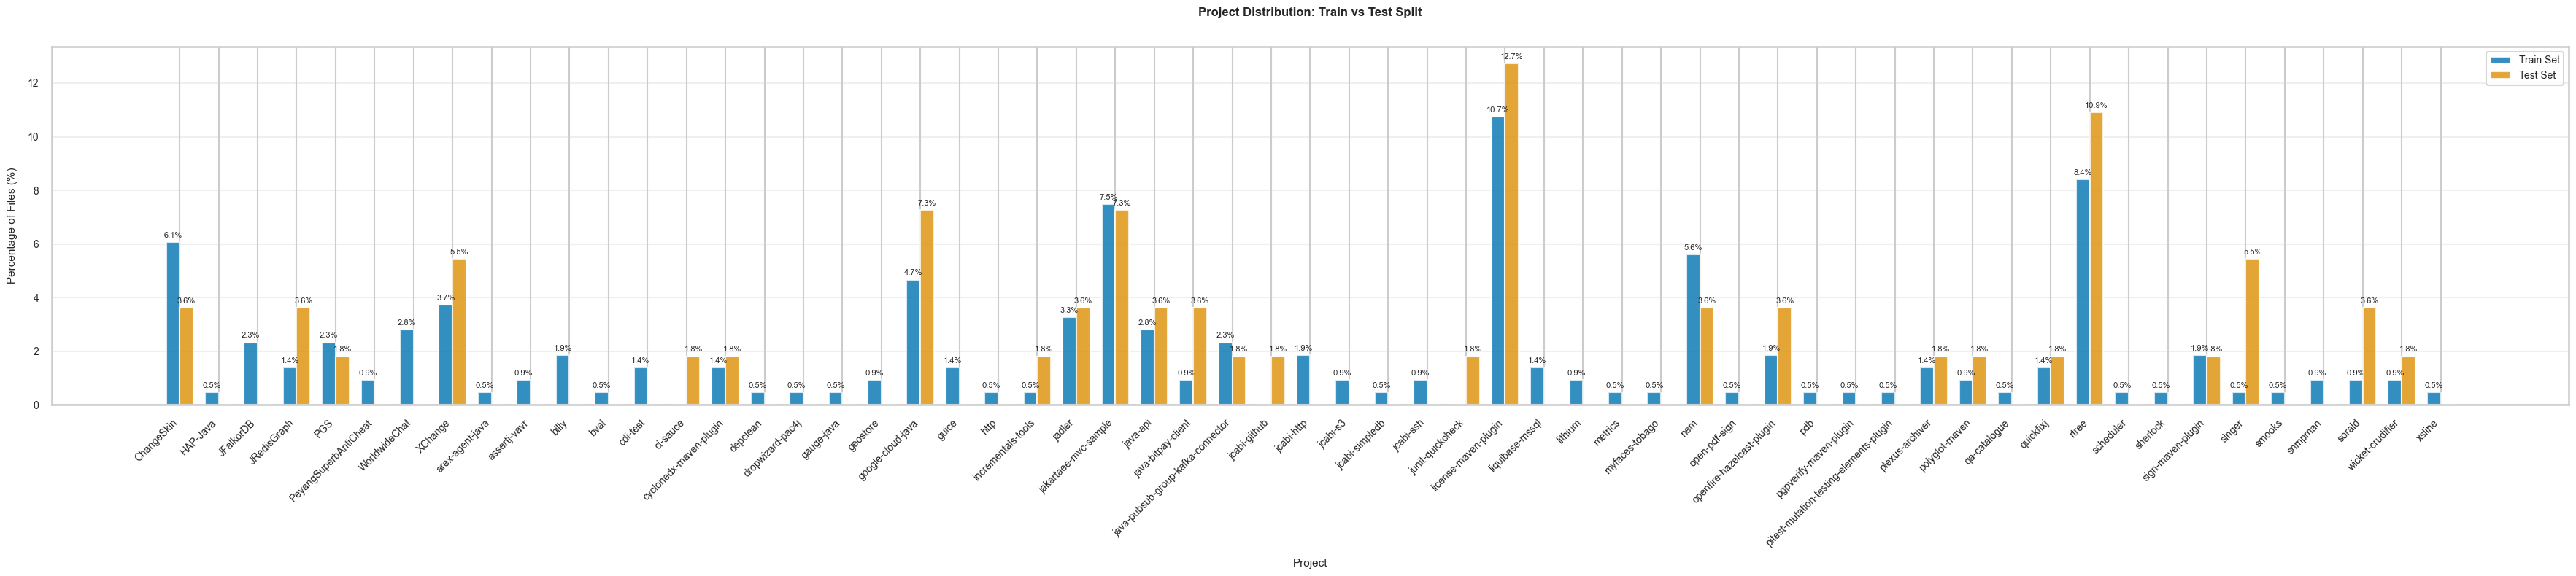

In [30]:
def plot_project_distribution_comparison(comparison_df: pd.DataFrame) -> None:
    """
    Visualizes the project distribution comparison between training and test datasets.
    
    :param comparison_df: A DataFrame with columns 'Project', 'Train %', 'Test %'.
    """
    all_projects = comparison_df['Project'].tolist()
    
    # Visualize project distribution balance
    fig, ax = plt.subplots(figsize=(max(10, len(all_projects) * 0.6), 8))
    x = np.arange(len(all_projects))
    width = 0.35
    
    bars1 = ax.bar(x - width / 2, comparison_df['Train %'], width, label='Train Set', alpha=0.8)
    bars2 = ax.bar(x + width / 2, comparison_df['Test %'], width, label='Test Set', alpha=0.8)
    
    ax.set_ylabel('Percentage of Files (%)', fontsize=11)
    ax.set_xlabel('Project', fontsize=11)
    ax.set_title('Project Distribution: Train vs Test Split', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_df['Project'], rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.annotate(f'{height:.1f}%',
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()


# Compute comparison and plot
project_comparison = compute_distribution_comparison('data/train_df_analysis.csv', 'data/test_set.csv', comparison_type='project')
plot_project_distribution_comparison(project_comparison)

#### Split Quality Assessment: Labeling Statistics

In [31]:
def compute_labeling_statistics(train_path: str, test_path: str) -> tuple[pd.DataFrame, pd.Series, pd.Series]:
    """
    Computes labeling statistics comparing training and test datasets.
    
    :param train_path: Path to the training dataset CSV file.
    :param test_path: Path to the test dataset CSV file.
    :return: A tuple (stats_df, train_label_counts, test_label_counts).
    """
    # Load datasets
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    
    # Parse bc_types
    train_df["bc_types"] = train_df["bc_types"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    test_df["bc_types"] = test_df["bc_types"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    
    # Compute label counts
    train_label_counts = train_df['bc_types'].apply(len)
    test_label_counts = test_df['bc_types'].apply(len)
    
    # Create stats data
    stats_data = {
        'Metric': [
            'Mean BC types per file',
            'Median BC types per file',
            'Std Dev BC types per file',
            'Min BC types per file',
            'Max BC types per file',
            'Single-label files',
            'Multi-label files',
            'Single-label %',
            'Multi-label %'
        ],
        'Train Set': [
            round(train_label_counts.mean(), 2),
            train_label_counts.median(),
            round(train_label_counts.std(), 2),
            int(train_label_counts.min()),
            int(train_label_counts.max()),
            int((train_label_counts == 1).sum()),
            int((train_label_counts > 1).sum()),
            round((train_label_counts == 1).sum() / len(train_df) * 100, 2),
            round((train_label_counts > 1).sum() / len(train_df) * 100, 2)
        ],
        'Test Set': [
            round(test_label_counts.mean(), 2),
            test_label_counts.median(),
            round(test_label_counts.std(), 2),
            int(test_label_counts.min()),
            int(test_label_counts.max()),
            int((test_label_counts == 1).sum()),
            int((test_label_counts > 1).sum()),
            round((test_label_counts == 1).sum() / len(test_df) * 100, 2),
            round((test_label_counts > 1).sum() / len(test_df) * 100, 2)
        ]
    }
    
    stats_df = pd.DataFrame(stats_data)
    
    # Compute numeric differences
    stats_df['Δ (Train - Test)'] = ''
    for i in range(len(stats_df)):
        try:
            diff = float(stats_df.loc[i, 'Train Set']) - float(stats_df.loc[i, 'Test Set'])
            stats_df.loc[i, 'Δ (Train - Test)'] = round(diff, 2)
        except:
            stats_df.loc[i, 'Δ (Train - Test)'] = '-'
    
    return stats_df, train_label_counts, test_label_counts


# Compute labeling statistics
stats_df, train_label_counts, test_label_counts = compute_labeling_statistics('data/train_df_analysis.csv', 'data/test_set.csv')
stats_df

,Metric,Train Set,Test Set,Δ (Train - Test)
0,Mean BC types per file,1.31,1.27,-
1,Median BC types per file,1.00,1.00,-
2,Std Dev BC types per file,0.80,0.71,-
3,Min BC types per file,1.00,1.00,-
4,Max BC types per file,5.00,4.00,-
5,Single-label files,181.00,47.00,-
6,Multi-label files,33.00,8.00,-
7,Single-label %,84.58,85.45,-
8,Multi-label %,15.42,14.55,-


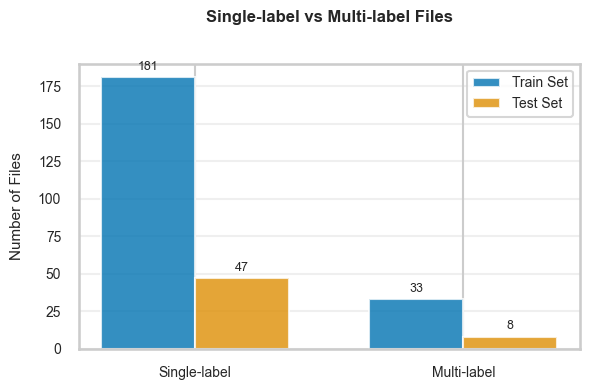

In [32]:
def plot_labeling_statistics(train_label_counts: pd.Series, test_label_counts: pd.Series) -> None:
    """
    Visualizes single-label vs multi-label files comparison between training and test datasets.
    
    :param train_label_counts: Series of label counts from training set.
    :param test_label_counts: Series of label counts from test set.
    """
    # Single vs Multi-label comparison
    categories = ['Single-label', 'Multi-label']
    train_vals = [(train_label_counts == 1).sum(), (train_label_counts > 1).sum()]
    test_vals = [(test_label_counts == 1).sum(), (test_label_counts > 1).sum()]
    
    fig, ax = plt.subplots(figsize=(6, 4))
    x = np.arange(len(categories))
    width = 0.35
    bars1 = ax.bar(x - width / 2, train_vals, width, label='Train Set', alpha=0.8)
    bars2 = ax.bar(x + width / 2, test_vals, width, label='Test Set', alpha=0.8)
    
    ax.set_ylabel('Number of Files', fontsize=11)
    ax.set_title('Single-label vs Multi-label Files', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{int(height)}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()


# Plot labeling statistics
plot_labeling_statistics(train_label_counts, test_label_counts)

## \<EOF\>